In [1]:
%matplotlib inline
from collections import defaultdict
from math import exp, log
from random import random
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## setup

In [2]:
rounds = 2_000
win_pcts_four_team_example = np.array([
    [0, 0.6, 0.7, 0.8],
    [0, 0,   0.6, 0.7],
    [0, 0,   0,   0.6],
    [0, 0,   0,   0],
])
win_pcts = np.array([
    [0, 0.7],
    [0, 0]
])

In [3]:
def create_data(win_pcts, rounds=10, as_dataframe=True):
    teams = len(win_pcts)
    recs = []
    # arr = np.random.random(size=(10_000, *win_pcts.shape)) < win_pcts
    for r in range(rounds):
        # enumerate upper triangle so each team plays every other team once
        # could allow home/away by using whole grid
        for team_a in range(teams):
            for team_b in range(team_a+1, teams):
                team_a_win_pct = win_pcts[team_a, team_b]
                team_a_wins = random() < team_a_win_pct
                recs.append((team_a, team_b, r, team_a_wins))
    if as_dataframe:
        return pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])
    return recs

In [4]:
recs = create_data(win_pcts, rounds=rounds, as_dataframe=False)
df = pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])

## logreg

In [5]:
# x = I(server) - I(receiver)
ta = pd.get_dummies(df['team_a'], dtype=np.int8)
tb = pd.get_dummies(df['team_b'], dtype=np.int8)
x = ta.subtract(tb, fill_value=0).astype(np.int8)
# high C is a low penalty
clf = LogisticRegression(C=1e10, fit_intercept=False, solver='lbfgs')
clf.fit(x, df['team_a_wins'])
clf.coef_

array([[ 0.42841996, -0.42841996]])

## elo

In [6]:
mean_rating = 0  # also the starting rating
ratings = defaultdict(lambda: mean_rating)
k = 1/300
# elo width/scale is just a rescaling so don't worry about it
post_ratings = []
for i, (team_a, team_b, r, team_a_wins) in enumerate(recs):
    ratings_diff = ratings[team_a] - ratings[team_b]
    expected_result = 1.0 / (1 + exp(-ratings_diff))
    change_in_rating = k*(team_a_wins - expected_result)
    ratings[team_a] += change_in_rating
    ratings[team_b] -= change_in_rating
    post_ratings.append((ratings[team_a], ratings[team_b]))

In [7]:
df = pd.DataFrame(recs, columns=['team_a', 'team_b', 'round', 'team_a_wins'])
dfr = pd.DataFrame(post_ratings, columns=['r_team_a', 'r_team_b'])
df = df.join(dfr)
df.head()

,team_a,team_b,round,team_a_wins,r_team_a,r_team_b
0,0,1,0,True,0.001667,-0.001667
1,0,1,1,True,0.003331,-0.003331
2,0,1,2,True,0.004992,-0.004992
3,0,1,3,False,0.003317,-0.003317
4,0,1,4,True,0.004978,-0.004978


## compare

In [8]:
def logistic(x):
    return 1 / (1 + np.exp(-x))
def logit(x):
    return np.log(x/(1-x))

In [9]:
true_rating = logit(win_pcts[0, 1]) / 2

Text(0, 0.5, 'strength')

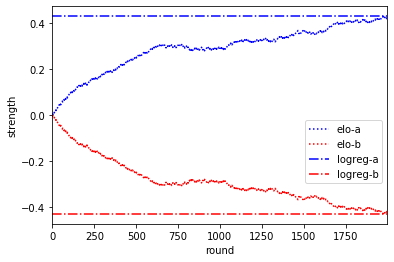

In [10]:
df.loc[df['team_a'] == 0, 'r_team_a'].plot(c='blue', label='elo-a', linestyle=':')
df.loc[df['team_b'] == 1, 'r_team_b'].plot(c='red', label='elo-b', linestyle=':')
plt.hlines(clf.coef_[0, 0], 0, rounds, color='blue', label='logreg-a', linestyle='-.')
plt.hlines(clf.coef_[0, 1], 0, rounds, color='red', label='logreg-b', linestyle='-.')
# plt.hlines(true_rating, 0, rounds, color='black')
# plt.hlines(-true_rating, 0, rounds, color='black')
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.xlabel('round')
plt.ylabel('strength')

**Elo is just gradient descent updates of logistic regression, which means that if strength is constant, given enough updates, elo will converge to the logreg result**. Actually, logreg will estimate the average strength

In [11]:
# and estimated win percentage
logistic(clf.coef_[0, 0] - clf.coef_[0, 1])

0.701999999996139